<a href="https://colab.research.google.com/github/correalipe/Betting-Data-Analysis/blob/main/Betting_KPIs_and_CRM_Level_Analysis_by_Sports_Competitions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# === 1. Montar Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.3 MB/s eta 0:00:00


/tmp/ipython-input-2-1767227768.py:40: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sports_df['Placed_YearMonth'] = sports_df['SportBetSettled_Placed'].dt.to_period('M').astype(str)


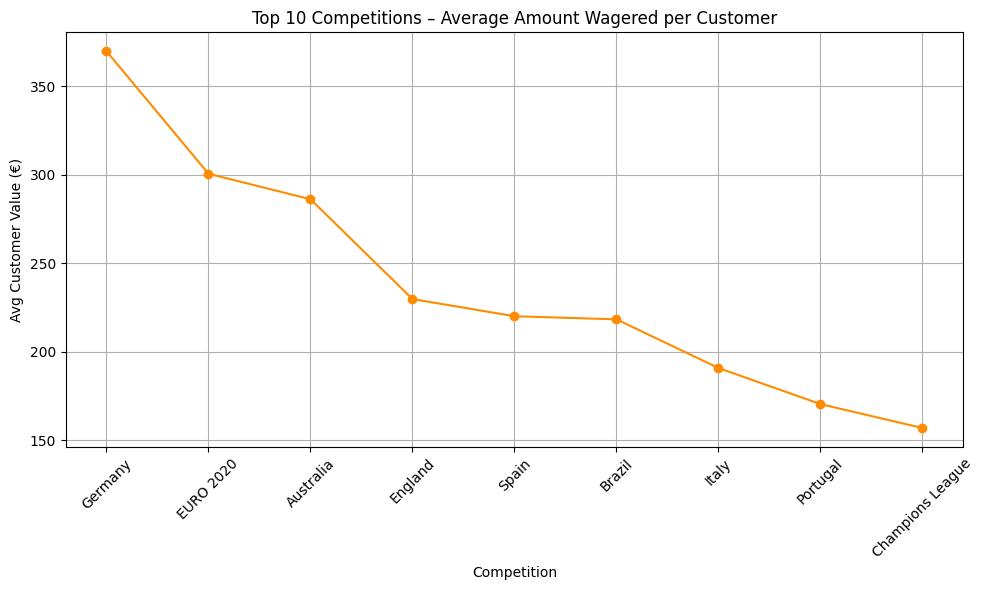

In [ ]:
# === 2. Importar bibliotecas ===
!pip install xlsxwriter

import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter

# === 3. Definir caminho base ===
base_path = '/content/drive/MyDrive/Task1 - Kaizen Gaming/'

# === 4. Carregar os arquivos ===
crm_df = pd.read_csv(base_path + 'CRM Level.csv', sep=';')
reg_df = pd.read_csv(base_path + 'Registrations.csv', sep=';')
sports_df = pd.read_csv(base_path + 'Sportbook.txt', sep=',', encoding='utf-8', engine='python')

# === 5. Padronizar nomes de colunas ===
crm_df.columns = crm_df.columns.str.strip()
reg_df.columns = reg_df.columns.str.strip()
sports_df.columns = sports_df.columns.str.strip()

# === 6. Renomear colunas necessárias ===
crm_df.rename(columns={'SportBetSettled_Customer_ID': 'Customer_ID'}, inplace=True)
reg_df.rename(columns={'SportBetSettled_Customer_ID': 'Customer_ID'}, inplace=True)
sports_df.rename(columns={'SportBetSettled_Customer_ID': 'Customer_ID'}, inplace=True)

# === 7. Tratar datas ===
crm_df = crm_df.dropna(subset=['Date_YearMonth'])
crm_df['Date_YearMonth'] = crm_df['Date_YearMonth'].astype(str).str.strip()
crm_df = crm_df[crm_df['Date_YearMonth'].str.match(r'^\d{6}$')]
crm_df['Date_YearMonth'] = pd.to_datetime(
    crm_df['Date_YearMonth'].str[:4] + '-' + crm_df['Date_YearMonth'].str[4:] + '-01',
    format='%Y-%m-%d'
)

reg_df['Registration_Date'] = pd.to_datetime(reg_df['Registration_Date'])
reg_df['Reg_YearMonth'] = reg_df['Registration_Date'].dt.to_period('M').astype(str)

sports_df['SportBetSettled_Placed'] = pd.to_datetime(sports_df['SportBetSettled_Placed'])
sports_df['SportBetSettled_Settled'] = pd.to_datetime(sports_df['SportBetSettled_Settled'])
sports_df['Placed_YearMonth'] = sports_df['SportBetSettled_Placed'].dt.to_period('M').astype(str)
sports_df['YearMonth'] = sports_df['Placed_YearMonth']

# === 8. Merge com registros e calcular First_Bet ===
sports_df = sports_df.merge(reg_df[['Customer_ID', 'Registration_Date', 'Reg_YearMonth']], on='Customer_ID', how='left')
sports_df['Is_First_Bet'] = sports_df['Placed_YearMonth'] == sports_df['Reg_YearMonth']

# === 9. Tabela 1: KPI por competição ===
tabela1 = sports_df.groupby('Event_Class_Name').agg(
    Bets=('SportBetSettled_Bet_ID', 'count'),
    Customers=('Customer_ID', 'nunique'),
    Turnover=('Turnover', 'sum'),
    Winnings=('Winnings', 'sum'),
    First_Bets=('Is_First_Bet', 'sum')
).reset_index()

tabela1['Gross_Revenue'] = tabela1['Turnover'] - tabela1['Winnings']
tabela1['Avg_Customer_Value'] = tabela1['Turnover'] / tabela1['Customers']
tabela1['Avg_Bet_Value'] = tabela1['Turnover'] / tabela1['Bets']

# === 10. Tabela 2: CRM Level por mês ===
sports_df['Placed_YearMonth'] = pd.to_datetime(sports_df['Placed_YearMonth'] + '-01')
sports_df['merge_key'] = sports_df['Customer_ID'].astype(str) + '_' + sports_df['Placed_YearMonth'].dt.strftime('%Y-%m')
crm_df['merge_key'] = crm_df['Customer_ID'].astype(str) + '_' + crm_df['Date_YearMonth'].dt.strftime('%Y-%m')

sports_df = sports_df.merge(crm_df[['merge_key', 'CRM_Level']], on='merge_key', how='left')

months_played = sports_df[['Customer_ID', 'Placed_YearMonth']].drop_duplicates()
crm_aux = crm_df[['Customer_ID', 'Date_YearMonth', 'CRM_Level']].copy().sort_values(['Customer_ID', 'Date_YearMonth'])
merged = months_played.merge(crm_aux, on='Customer_ID', how='left')
merged = merged[merged['Date_YearMonth'] <= merged['Placed_YearMonth']]
merged = merged.sort_values(['Customer_ID', 'Placed_YearMonth', 'Date_YearMonth']).groupby(['Customer_ID', 'Placed_YearMonth']).tail(1)

sports_df.drop(columns=['CRM_Level'], errors='ignore', inplace=True)
sports_df = sports_df.merge(merged[['Customer_ID', 'Placed_YearMonth', 'CRM_Level']], on=['Customer_ID', 'Placed_YearMonth'], how='left')

tabela2 = sports_df[['Customer_ID', 'Placed_YearMonth', 'CRM_Level']].drop_duplicates()
tabela2 = tabela2.groupby(['Placed_YearMonth', 'CRM_Level']).agg(Customers=('Customer_ID', 'nunique')).reset_index()

# === 11. Tabela 3: Novos clientes ===
sports_df['Reg_YearMonth'] = sports_df['Reg_YearMonth'].astype(str)
sports_novos = sports_df[sports_df['Placed_YearMonth'].dt.to_period('M').astype(str) == sports_df['Reg_YearMonth']]
tabela3 = sports_novos[['Customer_ID', 'Placed_YearMonth', 'CRM_Level']].drop_duplicates()
tabela3 = tabela3.groupby(['Placed_YearMonth', 'CRM_Level']).agg(Customers=('Customer_ID', 'nunique')).reset_index()

# Garantir formatos
tabela2['Placed_YearMonth'] = pd.to_datetime(tabela2['Placed_YearMonth'], errors='coerce')
tabela3['Placed_YearMonth'] = pd.to_datetime(tabela3['Placed_YearMonth'], errors='coerce')
tabela2['Customers'] = tabela2['Customers'].fillna(0).round().astype(int)
tabela3['Customers'] = tabela3['Customers'].fillna(0).round().astype(int)

# === 12. Gráfico extra ===
top_10 = tabela1.sort_values(by='Bets', ascending=False).head(10).sort_values(by='Avg_Customer_Value', ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(top_10['Event_Class_Name'], top_10['Avg_Customer_Value'], marker='o', linestyle='-', color='darkorange')
plt.title('Top 10 Competitions – Average Amount Wagered per Customer')
plt.xlabel('Competition')
plt.ylabel('Avg Customer Value (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(base_path + 'avg_customer_value_chart.png')
plt.show()

In [ ]:
# === Exportar CSVs ===
tabela1.to_csv(base_path + 'kpi_by_competition.csv', index=False)
tabela2.to_csv(base_path + 'crm_level_by_month.csv', index=False)
tabela3.to_csv(base_path + 'crm_level_by_month_new_customers.csv', index=False)

# === Formatos globais ===
money_format = None
int_format = None
date_format = None
integer_format_safe = None

# === Tabela 1: KPI por competição ===
with pd.ExcelWriter(base_path + 'kpi_by_competition.xlsx', engine='xlsxwriter') as writer:
    tabela1.to_excel(writer, index=False, sheet_name='KPI_by_Competition')
    workbook = writer.book
    worksheet = writer.sheets['KPI_by_Competition']

    money_format = workbook.add_format({'num_format': '€#,##0.00'})
    int_format = workbook.add_format({'num_format': '0'})
    date_format = workbook.add_format({'num_format': 'yyyy-mm'})
    integer_format_safe = workbook.add_format({'num_format': '0', 'align': 'right'})

    worksheet.set_column('A:A', 25)
    worksheet.set_column('B:C', 10, int_format)
    worksheet.set_column('D:E', 15, money_format)
    worksheet.set_column('F:F', 10, int_format)
    worksheet.set_column('G:I', 15, money_format)

# === Tabela 2: CRM Level por mês ===
with pd.ExcelWriter(base_path + 'crm_level_by_month.xlsx', engine='xlsxwriter', datetime_format='yyyy-mm') as writer:
    tabela2.to_excel(writer, index=False, sheet_name='CRM_Level_by_Month')
    workbook = writer.book
    worksheet = writer.sheets['CRM_Level_by_Month']

    worksheet.set_column('A:A', 15, date_format)
    worksheet.set_column('B:B', 15)
    worksheet.set_column('C:C', 12, integer_format_safe)

# === Tabela 3: Novos clientes por mês ===
with pd.ExcelWriter(base_path + 'crm_level_by_month_new_customers.xlsx', engine='xlsxwriter', datetime_format='yyyy-mm') as writer:
    tabela3.to_excel(writer, index=False, sheet_name='New_Customers_CRM')
    workbook = writer.book
    worksheet = writer.sheets['New_Customers_CRM']

    worksheet.set_column('A:A', 15, date_format)
    worksheet.set_column('B:B', 15)
    worksheet.set_column('C:C', 12, integer_format_safe)